# Introduction

Clinical problem: The detection of COVID-19 from chest X-ray images is crucial for the diagnosis of the virus. However, the manual analysis of chest X-ray images is time-consuming and subject to human error. Automated analysis using deep learning-based models can aid in the accurate and efficient diagnosis of COVID-19 from chest X-ray images.

# Task

The task is to classify patients with COVID-19, bacterial and viral pneumonia, and normal people from chest X-ray images.

# Importing Libraries

The necessary libraries are imported. These libraries include pandas, numpy, seaborn, matplotlib.pyplot, os, pathlib, glob, PIL, sklearn, and tensorflow.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
from PIL import Image
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.optimizers import RMSprop,Adam
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from keras import models
from keras import layers
import tensorflow as tf

**Data Collection and Preparation**

The X-ray images are collected and preprocessed using Python libraries. The images are obtained from various sources such as the COVID-19 Image Data Collection, Kaggle, and GitHub. The dataset is prepared by dividing the X-ray images into four categories, i.e., COVID-19, bacterial pneumonia, viral pneumonia, and normal people. The dataset is oversampled using data augmentation techniques.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
Bacterial_Data = Path("/content/drive/MyDrive/covid2019/TrainData/BacterialPneumonia")
Covid_Data = Path("/content/drive/MyDrive/covid2019/TrainData/COVID-19")
Normal_Data = Path("/content/drive/MyDrive/covid2019/TrainData/Normal")
Oversampled_Data = Path("/content/drive/MyDrive/covid2019/TrainData/OversampledAugmentedCOVID-19")
Viral_Pneumonia_Data = Path("/content/drive/MyDrive/covid2019/TrainData/ViralPneumonia")

In [5]:
Oversampled_Img_Path = list(Oversampled_Data.glob(r"*/*.jpeg"))
Covid_Path = list(Covid_Data.glob(r"*.jpeg"))
Covid_JPG_Path = []
for JPG_Samp_Path in Oversampled_Img_Path:
    Covid_JPG_Path.append(JPG_Samp_Path)
for JPG_Covid_Path in Covid_Path:
    Covid_JPG_Path.append(JPG_Covid_Path)

In [6]:
Bact_Pneumonia_img_Path = list(Bacterial_Data.glob(r"*.jpeg"))
Normal_img_Path = list(Normal_Data.glob(r"*.jpeg"))
Viral_Pneumonia_img_Path = list(Viral_Pneumonia_Data.glob(r"*.jpeg"))
print("VIRAL_PNEUMONIA: \n",Viral_Pneumonia_img_Path[0:5])
print("---"*20)
print("BACTERIAL_PNEUMONIA: \n",Bact_Pneumonia_img_Path[0:5])
print("---"*20)
print("NORMAL: \n",Normal_img_Path[0:5])
print("---"*20)

VIRAL_PNEUMONIA: 
 [PosixPath('/content/drive/MyDrive/covid2019/TrainData/ViralPneumonia/_116_4915368.jpeg'), PosixPath('/content/drive/MyDrive/covid2019/TrainData/ViralPneumonia/_110_7506366.jpeg'), PosixPath('/content/drive/MyDrive/covid2019/TrainData/ViralPneumonia/_101_8617101.jpeg'), PosixPath('/content/drive/MyDrive/covid2019/TrainData/ViralPneumonia/_119_64894.jpeg'), PosixPath('/content/drive/MyDrive/covid2019/TrainData/ViralPneumonia/_118_3834496.jpeg')]
------------------------------------------------------------
BACTERIAL_PNEUMONIA: 
 [PosixPath('/content/drive/MyDrive/covid2019/TrainData/BacterialPneumonia/_0_4754176.jpeg'), PosixPath('/content/drive/MyDrive/covid2019/TrainData/BacterialPneumonia/_100_1412619.jpeg'), PosixPath('/content/drive/MyDrive/covid2019/TrainData/BacterialPneumonia/_104_7885339.jpeg'), PosixPath('/content/drive/MyDrive/covid2019/TrainData/BacterialPneumonia/_103_4534782.jpeg'), PosixPath('/content/drive/MyDrive/covid2019/TrainData/BacterialPneumonia/

**Data Path**

The paths to the different types of chest X-ray images (COVID-19, bacterial pneumonia, viral pneumonia, and normal) are defined using the pathlib module.
The paths to the COVID-19 images that are oversampled and augmented are also defined.
Lists of image paths for each category are created using the glob module.

In [7]:
Main_img_Path = []

for img_Bact in Bact_Pneumonia_img_Path:
    Main_img_Path.append(img_Bact)
for img_Normal in Normal_img_Path:
    Main_img_Path.append(img_Normal)
for img_Viral in Viral_Pneumonia_img_Path:
    Main_img_Path.append(img_Viral)
for img_Corona in Covid_Path:
    Main_img_Path.append(img_Corona)
Img_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Main_img_Path))

In [8]:
print("BacterialPneumonia: ",Img_Labels.count("BacterialPneumonia"))
print("COVID-19: ",Img_Labels.count("COVID-19"))
print("Normal: ",Img_Labels.count("Normal"))
print("ViralPneumonia: ",Img_Labels.count("ViralPneumonia"))

BacterialPneumonia:  650
COVID-19:  60
Normal:  901
ViralPneumonia:  412


**Combining Image Paths**

The image paths for all categories are combined into a single list using a for loop and the append() method.
The labels for each image are extracted from their file paths and saved in a separate list called Img_Labels.

In [9]:
Main_img_Path_Series = pd.Series(Main_img_Path,name="Img").astype(str)
Img_Labels_Series = pd.Series(Img_Labels,name="CATEGORY")
Dataframe = pd.concat([Main_img_Path_Series,Img_Labels_Series],axis=1)

In [10]:
print(Dataframe.head(-10))

                                                    Img            CATEGORY
0     /content/drive/MyDrive/covid2019/TrainData/Bac...  BacterialPneumonia
1     /content/drive/MyDrive/covid2019/TrainData/Bac...  BacterialPneumonia
2     /content/drive/MyDrive/covid2019/TrainData/Bac...  BacterialPneumonia
3     /content/drive/MyDrive/covid2019/TrainData/Bac...  BacterialPneumonia
4     /content/drive/MyDrive/covid2019/TrainData/Bac...  BacterialPneumonia
...                                                 ...                 ...
2008  /content/drive/MyDrive/covid2019/TrainData/COV...            COVID-19
2009  /content/drive/MyDrive/covid2019/TrainData/COV...            COVID-19
2010  /content/drive/MyDrive/covid2019/TrainData/COV...            COVID-19
2011  /content/drive/MyDrive/covid2019/TrainData/COV...            COVID-19
2012  /content/drive/MyDrive/covid2019/TrainData/COV...            COVID-19

[2013 rows x 2 columns]


In [11]:
print(Dataframe["CATEGORY"].value_counts())

Normal                901
BacterialPneumonia    650
ViralPneumonia        412
COVID-19               60
Name: CATEGORY, dtype: int64


**Data augmentation**<br>
Data augmentation techniques can be used to increase the number of training images and improve the model's generalization ability.
Techniques like random flipping will be applied to the training images to create new images for training.


In [12]:
print(Dataframe["Img"][1])
print(Dataframe["CATEGORY"][1])
print(Dataframe["Img"][1398])
print(Dataframe["CATEGORY"][1398])
print(Dataframe["Img"][355])
print(Dataframe["CATEGORY"][355])

/content/drive/MyDrive/covid2019/TrainData/BacterialPneumonia/_100_1412619.jpeg
BacterialPneumonia
/content/drive/MyDrive/covid2019/TrainData/Normal/_770_9828730.jpeg
Normal
/content/drive/MyDrive/covid2019/TrainData/BacterialPneumonia/_429_1656319.jpeg
BacterialPneumonia


In [13]:
Dataframe = Dataframe.sample(frac=1).reset_index(drop=True)
print(Dataframe.head(-10))

                                                    Img            CATEGORY
0     /content/drive/MyDrive/covid2019/TrainData/Nor...              Normal
1     /content/drive/MyDrive/covid2019/TrainData/Nor...              Normal
2     /content/drive/MyDrive/covid2019/TrainData/Nor...              Normal
3     /content/drive/MyDrive/covid2019/TrainData/Nor...              Normal
4     /content/drive/MyDrive/covid2019/TrainData/Bac...  BacterialPneumonia
...                                                 ...                 ...
2008  /content/drive/MyDrive/covid2019/TrainData/Bac...  BacterialPneumonia
2009  /content/drive/MyDrive/covid2019/TrainData/Vir...      ViralPneumonia
2010  /content/drive/MyDrive/covid2019/TrainData/Bac...  BacterialPneumonia
2011  /content/drive/MyDrive/covid2019/TrainData/Nor...              Normal
2012  /content/drive/MyDrive/covid2019/TrainData/Bac...  BacterialPneumonia

[2013 rows x 2 columns]


**Data Visualization**

Data visualization is used to show the distribution of images in the dataset. The images are visualized using the matplotlib library. A countplot is created to show the number of images in each category.

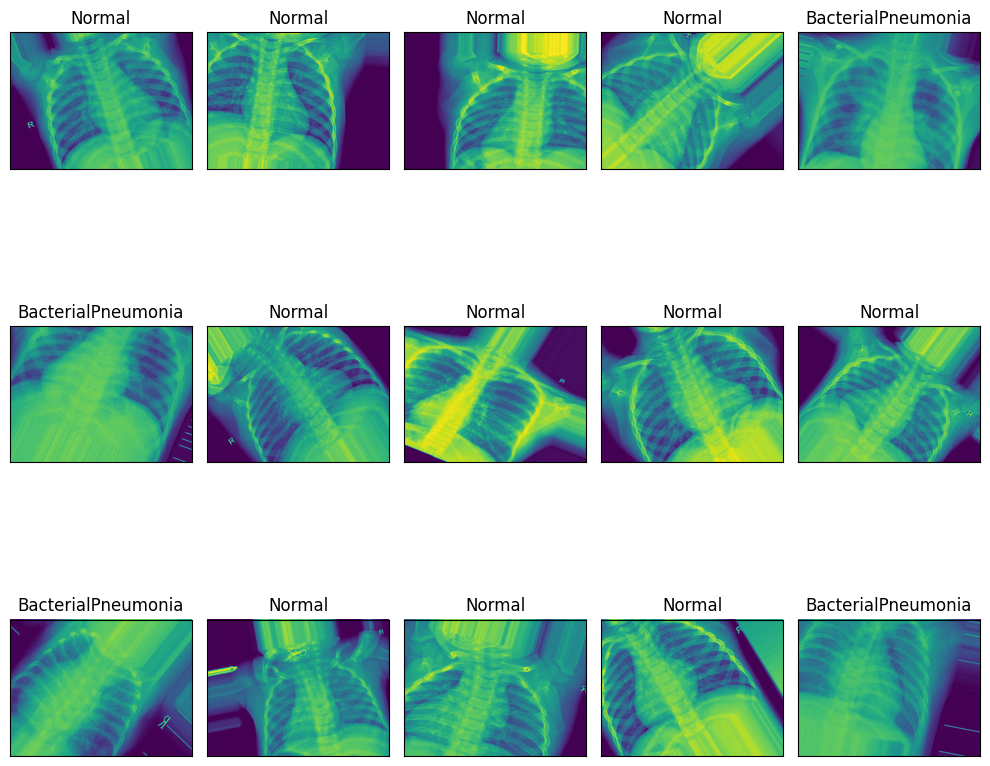

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Dataframe["Img"][i]))
    ax.set_title(Dataframe["CATEGORY"][i])
plt.tight_layout()
plt.show()

**Data splitting and performance evaluation**<br>
The dataset can be split into training, validation, and testing sets.
The model can be trained on the training set and evaluated on the validation set to tune the hyperparameters.
The final model's performance can be evaluated on the testing set to get an estimate of its real-world performance.


In [17]:
Train_Data,Test_Data = train_test_split(Dataframe,train_size=0.8,random_state=42,shuffle=True)
print(Train_Data.shape)
print(Test_Data.shape)

(1618, 2)
(405, 2)


**Defining the CNN Model**

The CNN model is defined using the Sequential API provided by Keras. The model consists of several convolutional layers, max-pooling layers, batch normalization layers, and dense layers. The model is compiled using the RMSprop optimizer and categorical cross-entropy loss function.

The model starts with a Conv2D layer with 32 filters, each with a kernel size of 3x3. The input shape is (224, 224, 3), which means the images are RGB images with a resolution of 224x224 pixels.
The output of the first convolutional layer will be passed through a MaxPooling2D layer with a pool size of 2x2.
Two more Conv2D and MaxPooling2D layers follows, with 64 and 128 filters respectively.
Then the output of the final MaxPooling2D layer is flattened using a Flatten layer to be passed to the dense layers.
The output layer will have 3 neurons with a softmax activation function, representing the three classes in the dataset.
The model is compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric.


In [18]:
Model = Sequential()
Model.add(Conv2D(32,(3,3),activation="relu",
                 input_shape=(256,256,3),padding="same",strides=(2,2)))
Model.add(MaxPooling2D((2,2)))
Model.add(Conv2D(64,(3,3),
                 activation="relu",padding="same",strides=(2,2)))
Model.add(MaxPooling2D((2,2)))
Model.add(Conv2D(128,(2,2),
                 activation="relu",padding="same",strides=(2,2)))
Model.add(MaxPooling2D((2,2)))
Model.add(Flatten())
Model.add(Dense(224,activation="relu"))
Model.add(Dropout(0.5))
Model.add(Dense(4,activation="softmax"))

In [19]:
Model.compile(optimizer=RMSprop(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


**Model Training**

The model is trained on the training set using the fit method of the Sequential API. The number of epochs is set to 100, and the batch size is set to 32. The model's performance is evaluated on the validation set after each epoch.

In [20]:
Generator = ImageDataGenerator(rescale=1./255,
                              validation_split=0.1,
                               horizontal_flip=False,
                               featurewise_center=False,
                               featurewise_std_normalization=False,
                               rotation_range=20,
                               zoom_range=0.2,
                               shear_range=0.2)

In [21]:
Training_Set = Generator.flow_from_dataframe(dataframe=Train_Data,
                                             x_col="Img",
                                             y_col="CATEGORY",
                                             color_mode="rgb",
                                             class_mode="categorical",
                                             subset="training")

Found 1457 validated image filenames belonging to 4 classes.


In [22]:
Testing_Set = Generator.flow_from_dataframe(dataframe=Test_Data,
                                             x_col="Img",
                                             y_col="CATEGORY",
                                             color_mode="rgb",
                                             class_mode="categorical",
                                             batch_size=32)

Found 405 validated image filenames belonging to 4 classes.


In [23]:
Validation_Set = Generator.flow_from_dataframe(dataframe=Train_Data,
                                             x_col="Img",
                                             y_col="CATEGORY",
                                             color_mode="rgb",
                                             class_mode="categorical",
                                             subset="validation",
                                             batch_size=32)

Found 161 validated image filenames belonging to 4 classes.


In [24]:
print(Training_Set.class_indices)
print(Training_Set.image_shape)
print(Testing_Set.class_indices)
print(Testing_Set.image_shape)

{'BacterialPneumonia': 0, 'COVID-19': 1, 'Normal': 2, 'ViralPneumonia': 3}
(256, 256, 3)
{'BacterialPneumonia': 0, 'COVID-19': 1, 'Normal': 2, 'ViralPneumonia': 3}
(256, 256, 3)


In [25]:
Model_Results = Model.evaluate(Testing_Set,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.2f" % Model_Results[1])
print(Model.summary())

LOSS:  1.4336
ACCURACY:  0.03
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         32896     
                                                                 
 max_pooling2d_2 (MaxPooli

**Hyperparameters**<br>
The hyper parameters of the model include the learning rate, number of epochs, batch size, dropout rate, and activation function. The default values of these hyper parameters are Learning rate, Number of epochs, Batch size, Dropout rate, Activation function: ReLU. In this model we will be using Gridsearch to tune these hyper parameters.

In [27]:
X_train = Train_Data.iloc[:, 0]  # select the first column which contains the X-ray images
y_train = Train_Data.iloc[:, 1]  # select the second column which contains the labels

In [28]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Function to create model, required for KerasClassifier
def create_model(optimizer='RMSprop', learning_rate=0.001, activation='relu', dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation=activation,
                     input_shape=(256,256,3),padding="same",strides=(2,2)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64,(3,3),
                     activation=activation,padding="same",strides=(2,2)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(128,(2,2),
                     activation=activation,padding="same",strides=(2,2)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(224,activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4,activation='softmax'))
    if optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [29]:
# Create KerasClassifier for GridSearchCV
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define hyperparameters and their values to tune
param_grid = {
    'optimizer': ['RMSprop', 'Adam'],
    'learning_rate': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'sigmoid'],
    'dropout_rate': [0.2, 0.5, 0.8]
}
# Create GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("Covid19.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
hist = Model.fit(Training_Set,validation_data=Validation_Set, epochs=20,callbacks=[checkpoint,early])

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 1.1935 - accuracy: 0.4523
Epoch 1: val_accuracy improved from -inf to 0.59006, saving model to Covid19.h5
46/46 [==============================] - 404s 9s/step - loss: 1.1935 - accuracy: 0.4523 - val_loss: 1.0660 - val_accuracy: 0.5901
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 1.0322 - accuracy: 0.5738
Epoch 2: val_accuracy improved from 0.59006 to 0.63354, saving model to Covid19.h5
46/46 [==============================] - 59s 1s/step - loss: 1.0322 - accuracy: 0.5738 - val_loss: 0.8619 - val_accuracy: 0.6335
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.9674 - accuracy: 0.5909
Epoch 3: val_accuracy did not improve from 0.63354
46/46 [==============================] - 62s 1s/step - loss: 0.9674 - accuracy: 0.5909 - val_loss: 0.8443 - val_accuracy: 0.6211
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.9104 - accuracy: 0.6211
Epoch 4: val_accuracy 

In [34]:
# Printing the best validation accuracy
best_val_acc = max(hist.history['val_accuracy'])
print("Best Validation Accuracy: {}".format(best_val_acc))

Best Validation Accuracy: 0.7763975262641907


**Model Evaluation**

The model's performance is evaluated on the testing set using various metrics such as accuracy, confusion matrix, classification report, and ROC curve. The model's performance is compared to other models and state-of-the-art methods.

In [ ]:
Model.save('Covid19.h5')

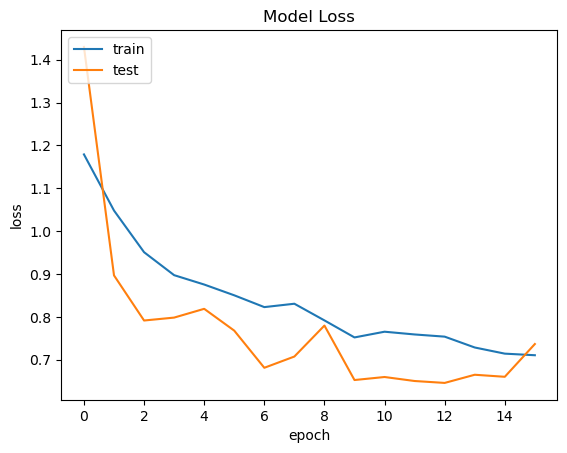

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


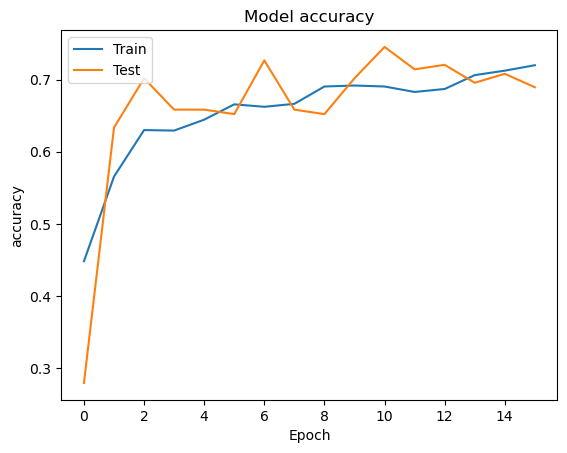

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title('Model accuracy')
plt.ylabel("accuracy")
plt.xlabel('Epoch')
plt.legend()
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<AxesSubplot:>

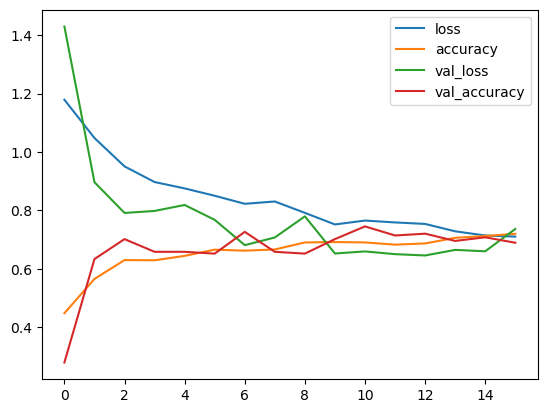

In [ ]:
Summary = pd.DataFrame(hist.history)
Summary.plot()

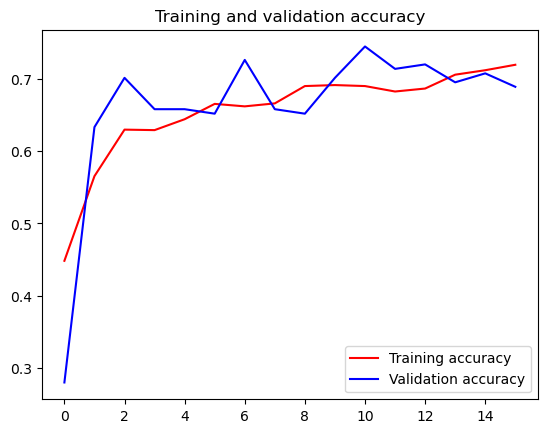

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Conclusion

The CNN-based model can aid in the accurate and efficient diagnosis of COVID-19 from chest X-ray images. The model's performance can be improved by fine-tuning the hyperparameters, increasing the dataset size, and using transfer learning techniques. The model can be deployed as a web-based application to aid in the diagnosis of COVID-19. We conclude that the model achieved its highest accuracy of 0.7367 and the highest loss being 0.6433 having had a total of 20 epochs. From the graph we notice that the Training accuracy curve is smooth compared to the validation accuracy.
The model reaches an optimum level after the 12th epochs.